In [10]:
from gwdetectors import *
import Functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# Define network, detector, signal

c = 299792458.0 # m/s

# try this, since we expect the detector response for + to be 0 directly overhead
detector = TwoArmDetector('test', PSDS[KNOWN_PSDS[1]], (0, 0, 0), arms = ((2e-5, 0, 0), (0, 2e-5, 0)))

flipped_H = TwoArmDetector('flipped_H', PSDS[KNOWN_PSDS[0]], 
                           np.array([-2.16141492636e+06, -3.83469517889e+06, +4.60035022664e+06])/c,
                           (np.array([-0.22389266154, +0.79983062746, +0.55690487831]) * 4e3/c, 
                            np.array([+0.91397818574, +0.02609403989, -0.40492342125]) * 4e3/c), 
                           long_wavelength_approximation=False)

K_instantiator, K_loc, K_arms = DETECTOR_ORIENTATIONS['K']

G_instantiator, G_loc, G_arms = DETECTOR_ORIENTATIONS['G']

Geo = G_instantiator('Geo', PSDS[KNOWN_PSDS[0]], G_loc, G_arms, long_wavelength_approximation=False)

kagra = K_instantiator('Kagra', PSDS[KNOWN_PSDS[0]], K_loc, K_arms, long_wavelength_approximation=False)

network = Network(DETECTORS['H_aligo-design'], DETECTORS['L_aligo-design'], 
                  DETECTORS['V_advirgo-design'], DETECTORS['CE@L_ce-design'], kagra)#, kagra, Geo)

fsr = 1 / (2 * np.sum(DETECTORS['CE@L_ce-design'].arms[0]**2)**0.5)

# Pick shape of sine-Gaussian signal pulse
a = fsr # frequency of sinusoidal component 
A = 1e-23 # Gaussian peak amplitude
c = 1e-3 # standard deviation of Gaussian envelope
dt= 0
p = 0

numpts=120
spread=4

freqs, ast_signal = Functions.produce_freqs_signal(numpts, spread, a, A, c, dt, p)

info = {'a': a, 'A': A, 'c': c, 'dt':dt, 'phi':p, 'network':network}

In [12]:
# Parameters for "true" data

az_true=0
po_true=0
psi_true=0
geocent=0
true_keys=['hp']
coord = 'geographic'

true_modes = dict.fromkeys(true_keys, ast_signal)

data = network.project(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)

true_snr = network.snr(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)

true_params = {'pole': po_true, 'azim':az_true,
               'psi': psi_true, 'geocent':geocent, 'modes':true_keys
              }

In [13]:
true_snr

0.6927200275597001

In [14]:
# Create dictionary with true parameters to store results

current_dict = {}

In [15]:
# Calculates optimization over t0, psi, phi0 for a grid of sky locations

npts=30 # resolution for psi, t0 
ranges=((0, np.pi), (dt-0.05, dt+0.05))
ranges_slice = ((0, np.pi, np.pi/45), (0, 2*np.pi, 2*np.pi/90)) #(dt-0.05, dt+0.05, 0.1/2)
finish_fun=None # note: make finish_fun None, this might be why values of psi are out of bounds
geocent=0
coord='geographic'
keys=['hb']

num=45 # resolution for azims, poles

azimuths = np.linspace(-np.pi, np.pi, num)
poles = np.flip(np.linspace(0, np.pi, num))

Azimuths, Poles = np.meshgrid(azimuths[1:], poles[1:], indexing='ij')
Azimuths_flat = Azimuths.flatten()
Poles_flat = Poles.flatten()
Coords_flat = list(zip(Azimuths_flat, Poles_flat))

optimization_variables = [a, A, c, network, freqs, geocent, data, coord, keys, 0]

if __name__ == '__main__':
    filter_grid = Functions.main_cf(None, num, Coords_flat, 
                                 Functions.filter_2a, ranges_slice, npts, finish_fun, 
                                 optimization_variables)

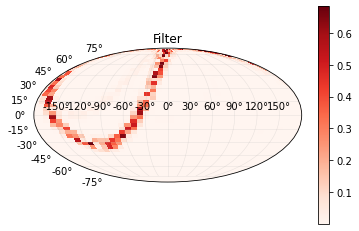

In [16]:
# Plot filter over sky locations

phi_plt = np.linspace(-np.pi, np.pi, num-1)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num-1)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, filter_grid, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

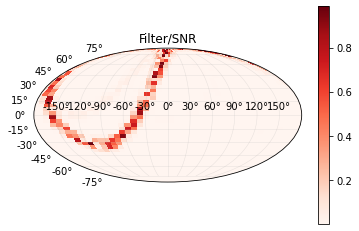

In [17]:
# Plot filter/true snr over sky

phi_plt = np.linspace(-np.pi, np.pi, num-1)
theta_plt = np.linspace(-np.pi/2., np.pi/2.,num-1)
Phi, Theta = np.meshgrid(phi_plt, theta_plt, indexing='ij')

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Phi,Theta, filter_grid/true_snr, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.title('Filter/SNR')
ax.grid(alpha=0.3, linewidth=0.5)
plt.show()

In [18]:
# Overall match

max_filter = np.max(filter_grid)
rho_match = max_filter / true_snr

print(f"Max filter: {max_filter}")
print(f"Match: {rho_match}")

Max filter: 0.6835996744951879
Match: 0.9868339982941721


In [19]:
# Find sky parameters that give maximum filter response

max_skyindex = np.where(filter_grid == np.max(filter_grid))
max_skyindex_coords = list(zip(max_skyindex[0], max_skyindex[1])) # repacking into coordinate indexes
max_sky_coords = [(azimuths[1:][azim_index], poles[1:][pole_index]) 
                  for (azim_index, pole_index) in max_skyindex_coords]
print(max_sky_coords)
max_az, max_po = max_sky_coords[0]

[(0.0, 0.07139983303613166)]


In [20]:
# Find parameters that give maximum filter response

if len(max_sky_coords) == 1: 
    max_vars = Functions.brute_max(Functions.filter_2a, ranges_slice, npts, finish_fun, *optimization_variables, 
                               max_az, max_po)[0]
else: 
    max_vars_all = [[Functions.brute_max(Functions.filter_2a, ranges_slice, npts, finish_fun, 
                                         *optimization_variables, max_az, max_po)[i]] 
                    for i in len(max_sky_coords)]
    max_vars = max_vars_all[0]

print(max_vars)
max_psi, max_phi = max_vars
print(f"Max azim: {max_az}, max pole: {max_po}, max psi: {max_psi}, max_phi: {max_phi}")

[0.         0.13962634]
Max azim: 0.0, max pole: 0.07139983303613166, max psi: 0.0, max_phi: 0.13962634015954636


In [21]:
# test against true parameters (except polarization mode)

test_mode = dict.fromkeys(keys, ast_signal)

strain = network.project(freqs, geocent, az_true, po_true, psi_true, coord=coord, **test_mode)
snrs = network.testsnr(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)

print(f'True SNR:{true_snr}')
print(f'SNRS:{snrs}')
print(f'Filters:{network.testfilter(freqs, data, strain)}')
filter=np.sum(np.array(network.testfilter(freqs, data, strain))**2) ** 0.5
print(f'Filter{filter.real}')
print(f'Match:{filter.real/true_snr}')
print(f'Parameters:{az_true, po_true, psi_true, 0, 0}')

True SNR:0.6927200275597001
SNRS:[0.03785013 0.02772536 0.00484577 0.69110213 0.003751  ]
Filters:[-0.02997755+2.30861027e-02j -0.02767562-1.65842286e-03j
  0.0048284 -4.09509206e-04j -0.17758874-6.60174350e-01j
  0.00374132-2.69019947e-04j]
Filter0.17689237879998684
Match:0.25535912311231956
Parameters:(0, 0, 0, 0, 0)


In [22]:
# validate optimization result

optimized_signal = Functions.ft_sine_Gaussian(freqs, a, A, c, 0, max_phi)

test_mode = dict.fromkeys(keys, optimized_signal)

opt_strain = network.project(freqs, geocent, max_az, max_po, max_psi, coord=coord, **test_mode)
snrs = network.testsnr(freqs, geocent, az_true, po_true, psi_true, coord=coord, **true_modes)

print(f'True SNR:{true_snr}')
print(f'SNRS:{snrs}')
print(f'Filters:{network.testfilter(freqs, data, opt_strain)}')
filter=np.sum(np.array(network.testfilter(freqs, data, opt_strain))**2) ** 0.5
print(f'Filter:{filter.real}')
print(f'Match:{filter.real/true_snr}')
print(f'Parameters:{max_az, max_po, max_psi, 0, max_phi}')

True SNR:0.6927200275597001
SNRS:[0.03785013 0.02772536 0.00484577 0.69110213 0.003751  ]
Filters:[-0.00362293+0.03190228j -0.01485357+0.02338066j  0.00209469-0.00187892j
 -0.68342122-0.06121887j -0.00241088-0.00022575j]
Filter:0.6823990352820258
Match:0.9851007739533202
Parameters:(0.0, 0.07139983303613166, 0.0, 0, 0.13962634015954636)


In [23]:
# save parameters
run_results = {'match': rho_match, 
               'pole': max_po, 'azim':max_az,
               'psi': max_psi, 
               'phi':max_phi
              }

current_dict["_".join(keys)] = run_results

In [79]:
# save filter grid array
np.savetxt(f"results/{true_keys}_{"_".join(keys)}.txt", filter_grid)

## Final results

In [24]:
# Convert parameter dictionaries into dataframe

df_info = pd.DataFrame.from_dict(info)
df_trueparams = pd.DataFrame.from_dict(true_params)

In [81]:
# Convert results dictionary into dataframe

df_results = pd.DataFrame.from_dict(current_dict)

In [82]:
# Store final results for a set of true parameters

import os

run_name = 'detectors_match'

folder_path = f'./results/{run_name}'
if not os.path.exists(folder_path):
    os.makedirs(folder_path, exist_ok=True)

df_info.to_csv(f'results/{run_name}/{"_".join(true_keys)}_info.csv')
df_trueparams.to_csv(f'results/{run_name}/{"_".join(true_keys)}_trueparams.csv')
df_results.to_csv(f'results/{run_name}/{"_".join(true_keys) +"-" + "_".join(keys)}.csv')

## Test individual detectors

In [25]:
test_dict={}

npts=30 # resolution for psi, t0 
ranges=((0, np.pi), (dt-0.05, dt+0.05))
ranges_slice = ((0, np.pi, np.pi/45), (0, 2*np.pi, 2*np.pi/90)) #(dt-0.05, dt+0.05, 0.1/2)
finish_fun=None # note: make finish_fun None, this might be why values of psi are out of bounds
geocent=0
coord='geographic'
keys=['hp']

num=45 # resolution for azims, poles

azimuths = np.linspace(-np.pi, np.pi, num)
poles = np.flip(np.linspace(0, np.pi, num))

Azimuths, Poles = np.meshgrid(azimuths[1:], poles[1:], indexing='ij')
Azimuths_flat = Azimuths.flatten()
Poles_flat = Poles.flatten()
Coords_flat = list(zip(Azimuths_flat, Poles_flat))

if __name__=='__main__':
    for i, detector in enumerate(network.detectors):
        optimization_variables = [a, A, c, detector, freqs, geocent, data[i], coord, keys, 0]
        true_snr = detector.snr(freqs, data[i])
        filter_grid = Functions.main_cf(None, num, Coords_flat, 
                                        Functions.filter_2a_det, ranges_slice, npts, finish_fun,
                                        optimization_variables)
        max_filter = np.max(filter_grid)
        rho_match = max_filter / true_snr

        max_skyindex = np.where(filter_grid == np.max(filter_grid))
        max_skyindex_coords = list(zip(max_skyindex[0], max_skyindex[1])) # repacking into coordinate indexes
        max_sky_coords = [(azimuths[1:][azim_index], poles[1:][pole_index]) 
                          for (azim_index, pole_index) in max_skyindex_coords]
        max_az, max_po = max_sky_coords[0]

        if len(max_sky_coords) == 1: 
            max_vars = Functions.brute_max(Functions.filter_2a_det, ranges_slice, npts, finish_fun, 
                                           *optimization_variables, 
                                           max_az, max_po)[0]
        else: 
            max_vars = [Functions.brute_max(Functions.filter_2a_det, ranges_slice, npts, finish_fun, 
                                             *optimization_variables, 
                                             max_az, max_po) for max_az, max_po in max_sky_coords]

        results = {'max_filter':max_filter, 'match':rho_match, 'max sky coords':max_sky_coords, 'max_vars':max_vars}
        test_dict[f'{i}'] = results

In [26]:
df_test_dict = pd.DataFrame.from_dict(test_dict)
df_test_dict

,0,1,2,3,4
max_filter,0.03785,0.027725,0.004846,0.691102,0.003751
match,1.0,1.0,1.0,1.0,1.0
max sky coords,"[(-1.5707963267948966, 0.0), (0.0, 0.0), (1.57...","[(-1.5707963267948966, 0.0), (0.0, 0.0), (1.57...","[(-1.5707963267948966, 0.0), (0.0, 0.0), (1.57...","[(3.141592653589793, 0.0)]","[(-1.5707963267948966, 0.0), (0.0, 0.0)]"
max_vars,"[([0.0, 1.7453292519943295], 0.037850127494915...","[([0.0, 1.6755160819145565], 0.027725361615960...","[([0.0, 1.6057029118347832], 0.004845767797503...","[0.0, 0.20943951023931956]","[([0.0, 3.5604716740684323], 0.003750997645952..."


In [85]:
df_test_dict.to_csv(f'results/{run_name}/{"_".join(true_keys)}_detectors.csv')